# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need? in thin the
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

### Download and import libraries
Comment in the following two lines in case some of the libraries cannot be imported. Please restart the kernel after download+upgrade has successfully finished

In [3]:
### Download libraries
#%pip install uproot
#%pip install awkward
#%pip install mplhep
#%pip install numpy
#%pip install matplotlib
#%pip install scipy

### Upgrade libraries to latest version
#%pip install uproot awkward mplhep numpy matplotlib scipy --upgrade

In [4]:
import uproot
import awkward as ak
import mplhep
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
from scipy.optimize import curve_fit

%matplotlib inline
plt.rcParams.update({'font.size': 11})

## Import Monte Carlo Samples and define Cuts
First, we will open the Monte Carlo samples using `uproot`.

The datasets are converted to a pandas data frame. Available keys are:

| Variable name | Description |
| --- | --- | 
| ``run`` | Run number |
| ``event`` | Event number |
| ``Ncharged`` | Number of charged tracks |
| ``Pcharged`` | Total scalar sum of track momenta |
| ``E_ecal`` | Total energy measured in the electromagnetic calorimeter |
| ``E_hcal`` | Total energy measured in the hadronic calorimete |
| ``E_lep`` | LEP beam energy (=$\sqrt{s}/2$) |
| ``cos_thru`` | cosine of the polar angle between beam axis and thrust axis |
| ``cos_thet`` | cosine of the polar angle between incoming positron and outgoing positive particle |

If ``cos_thru`` or ``cos_thet`` are undefined, the value ``999`` is used to idicate that. This is replaced by ``NaN`` to ensure correct behaviour in calculations.

Furthermore, we reject values larger $100\,\mathrm{MeV}$ for ``Pcharged`` as unphysical, replacing them also with ``NaN``. This is necessary, since outliers $>10000\,\mathrm{MeV}$ disturb the plotting routine and averaging procedures.

In [5]:
path_mc = 'opal_data/mc/'   # monte-carlo simulations

### Open the file introducing file path
ee = uproot.open(path_mc+'ee.root')
mm = uproot.open(path_mc+'mm.root')
tt = uproot.open(path_mc+'tt.root')
qq = uproot.open(path_mc+'qq.root')
ttree_name = 'myTTree'

### Get list of 'branches' of the TTree (i.e. list of variable names)
keys = ee[ttree_name].keys()

## Load branches
ee_branches = ee[ttree_name].arrays()
mm_branches = mm[ttree_name].arrays()
tt_branches = tt[ttree_name].arrays()
qq_branches = qq[ttree_name].arrays()

## Convert to pandas data frame
simulated_electron = ak.to_pandas(ee_branches)
simulated_muon = ak.to_pandas(mm_branches)
simulated_tau = ak.to_pandas(tt_branches)
simulated_quark = ak.to_pandas(qq_branches)

## Efficiency correction factor (between nominal 100,000 events and the actual number of events)
eff_corr_electons = len(simulated_electron) / 1e5
eff_corr_muons = len(simulated_muon) / 1e5
eff_corr_taus = len(simulated_tau) / 1e5
eff_corr_quarks = len(simulated_quark) / 1e5

## Delete photon-photon entries
simulated_electron = simulated_electron[simulated_electron['Pcharged']!=0]
simulated_muon = simulated_muon[simulated_muon['Pcharged']!=0]
simulated_tau = simulated_tau[simulated_tau['Pcharged']!=0]
simulated_quark = simulated_quark[simulated_quark['Pcharged']!=0]

## Iterable arrays of different event types
simulated_datasets = {'electron': simulated_electron, 'muon': simulated_muon, 'tau': simulated_tau, 'quark': simulated_quark}
efficiency_corrections = {'electron': eff_corr_electons, 'muon': eff_corr_muons, 'tau': eff_corr_taus, 'quark': eff_corr_quarks}

## Use correct NaN specifier for undefined values
for particle, dataset in simulated_datasets.items():
    dataset['cos_thru'].replace(999, np.nan, inplace=True)
    dataset['cos_thet'].replace(999, np.nan, inplace=True)
    dataset['Pcharged'].mask(dataset['Pcharged']>100, inplace=True)

### Visualization of the dataset

We can now look at the ditribution of values for the physical quantities of the dataset.

For that, we plot histograms of all keys in the data frame except ``run`` and ``event`` number and the LEP beam energy, which for those samples was always constant.

In [6]:
# Relevant variables within the sample
relevant_variables = ['Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'cos_thru', 'cos_thet']

# Show histograms for each dataset with pandas
if False:   # set True to print all the histograms
    for particle, dataset in simulated_datasets.items():
        print(particle)
        diagram_list = dataset.hist(bins=50, column=relevant_variables)
        plt.tight_layout()
        plt.show()

For a better visualization of the parameter space, we can also plot each set of two variables in a scatter plot:

In [7]:
## get the default matplotlib color cycle as indexable array (needed to later prepare the legend)
prop_cycle = plt.rcParams['axes.prop_cycle']
default_colors = prop_cycle.by_key()['color']


## plot all combinations of interesting variables except for the angles
if False:
    for i in range(4):   # variable to be plotted on the x axis
        for j in range(i+1, 4):   # variable to be plotted on the y axis

            # plot faint datapoints
            for k, (particle, dataset) in enumerate(simulated_datasets.items()):
                plt.plot(dataset[relevant_variables[i]], dataset[relevant_variables[j]], '.', ms=0.2, alpha=0.1)   # actual data
                plt.plot([], [], '.', color=default_colors[k], ms=5, alpha=1, label=particle)   # better visible dots for legend

            plt.xlabel(relevant_variables[i])
            plt.ylabel(relevant_variables[j])
            plt.grid()
            plt.legend()
            plt.show()

### Declaring cuts

Separating the quark contributions is easily possible by their large number of charged traces:

We declare all events with `Ncharged >= 10` to be quark events, all with `Ncharged <=6` to be non-quark events.

For the leptons we could see the largest spread in the `Pcharged`-`E_ecal` 2D plot, there we choose regions differenciate the three types.

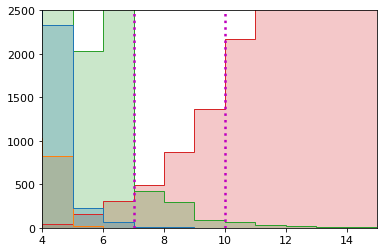

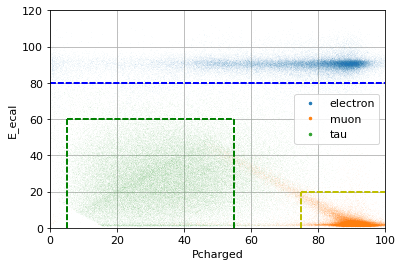

In [8]:
## declare cuts
Nmin_quarks = 10
Nmax_leptons = 6
Emin_ele = 80
Emax_muons = 20
Pmin_muons = 75
Emax_taus = 60
Pmin_taus = 5
Pmax_taus = 55



## plot histogram
histogram_data = [simulated_electron['Ncharged'],simulated_muon['Ncharged'],simulated_tau['Ncharged'],simulated_quark['Ncharged']]
plt.hist(histogram_data, histtype='step', bins=48, color=default_colors[:4])   # outline
plt.hist(histogram_data, histtype='stepfilled', bins=48, alpha=0.25, color=default_colors[:4])   # filling
plt.plot([Nmin_quarks, Nmin_quarks], [0, 1e4], c='m', ls=':', lw=2.5)  # plot separating lines
plt.plot([Nmax_leptons+1, Nmax_leptons+1], [0, 1e4], c='m', ls=':', lw=2.5)  # plot separating lines
plt.plot()
plt.xlim(4,15)
plt.ylim(0,2500)
#plt.savefig('figures/selection_histogram.pdf')
plt.show()


## scatter plot
for k, (particle, dataset) in enumerate(simulated_datasets.items()):
    if particle != 'quark':
        plt.plot(dataset['Pcharged'], dataset['E_ecal'], '.', ms=0.2, alpha=0.1)   # actual data
        plt.plot([], [], '.', color=default_colors[k], ms=5, alpha=1, label=particle)   # better visible dots for legend
    
    ## visualize cuts by plotting separating lines
    plt.plot([0, 100], [Emin_ele, Emin_ele], c='b', ls='--', lw=1.5)
    plt.plot([Pmin_muons, Pmin_muons], [0, Emax_muons], c='y', ls='--', lw=1.5)
    plt.plot([Pmin_muons, 100], [Emax_muons, Emax_muons], c='y', ls='--', lw=1.5)
    plt.plot([Pmin_taus, Pmax_taus], [Emax_taus, Emax_taus], c='g', ls='--', lw=1.5)
    plt.plot([Pmin_taus, Pmin_taus], [0, Emax_taus], c='g', ls='--', lw=1.5)
    plt.plot([Pmax_taus, Pmax_taus], [0, Emax_taus], c='g', ls='--', lw=1.5)

plt.xlabel('Pcharged')
plt.ylabel('E_ecal')
plt.grid()
plt.legend()
plt.xlim(0, 100)
plt.ylim(0,120)
#plt.savefig('figures/selection_scatter.pdf')
plt.show()


## define functions to produce the cutting mask on any dataset

def electron_mask(dataset):
    return np.all((dataset['Ncharged'] <= Nmax_leptons, dataset['E_ecal'] >= Emin_ele), axis=0)

def muon_mask(dataset):
    return np.all((dataset['Ncharged'] <= Nmax_leptons, dataset['E_ecal'] <= Emax_muons, dataset['Pcharged'] >= Pmin_muons), axis=0)

def tau_mask(dataset):
    return np.all((dataset['Ncharged'] <= Nmax_leptons, dataset['E_ecal'] <= Emax_taus,
                   dataset['Pcharged'] >= Pmin_taus, dataset['Pcharged'] <= Pmax_taus), axis=0)

def quark_mask(dataset):
    return dataset['Ncharged'] >= Nmin_quarks

## Iterable array of different selection types
selection_masks = {'electron': electron_mask, 'muon': muon_mask, 'tau': tau_mask, 'quark': quark_mask}

Applying those cuts to the monte carlo data gives us the selection efficiencies; via matrix inversion the correcting factors for the measured data can be calculated.

In [9]:
## calculate and save selection rates
selection_rates = np.zeros((4,4))
selection_errors = np.zeros((4,4))

for i, (particle, dataset) in enumerate(simulated_datasets.items()):
    for j, (rule_particle, selection_rule) in enumerate(selection_masks.items()):
        mask = selection_rule(dataset)
        selection_rates[i][j] = sum(mask)/len(mask) * efficiency_corrections[particle]
        selection_errors[i][j] = np.sqrt(sum(mask))/len(mask) * efficiency_corrections[particle]
        print(f"Out of {len(mask)} " + particle + f"-events, {np.sum(mask)} passed the " + rule_particle + "-selection mask")
        
print('Selection rates: \n', selection_rates)    

Out of 52113 electron-events, 49656 passed the electron-selection mask
Out of 52113 electron-events, 0 passed the muon-selection mask
Out of 52113 electron-events, 35 passed the tau-selection mask
Out of 52113 electron-events, 0 passed the quark-selection mask
Out of 89887 muon-events, 1 passed the electron-selection mask
Out of 89887 muon-events, 82676 passed the muon-selection mask
Out of 89887 muon-events, 992 passed the tau-selection mask
Out of 89887 muon-events, 0 passed the quark-selection mask
Out of 78826 tau-events, 136 passed the electron-selection mask
Out of 78826 tau-events, 220 passed the muon-selection mask
Out of 78826 tau-events, 65184 passed the tau-selection mask
Out of 78826 tau-events, 148 passed the quark-selection mask
Out of 98561 quark-events, 7 passed the electron-selection mask
Out of 98561 quark-events, 0 passed the muon-selection mask
Out of 98561 quark-events, 193 passed the tau-selection mask
Out of 98561 quark-events, 95307 passed the quark-selection ma

Errors for the inverse matrix:
[[5.00992006e-03 4.98331584e-07 1.81308252e-04 3.13632486e-07]
 [1.37273619e-05 4.01361771e-03 5.90500352e-04 2.52238349e-06]
 [1.99698955e-04 2.62491453e-04 5.98966319e-03 1.96807290e-04]
 [3.09968342e-05 7.82842847e-07 2.24570799e-04 3.40059716e-03]]


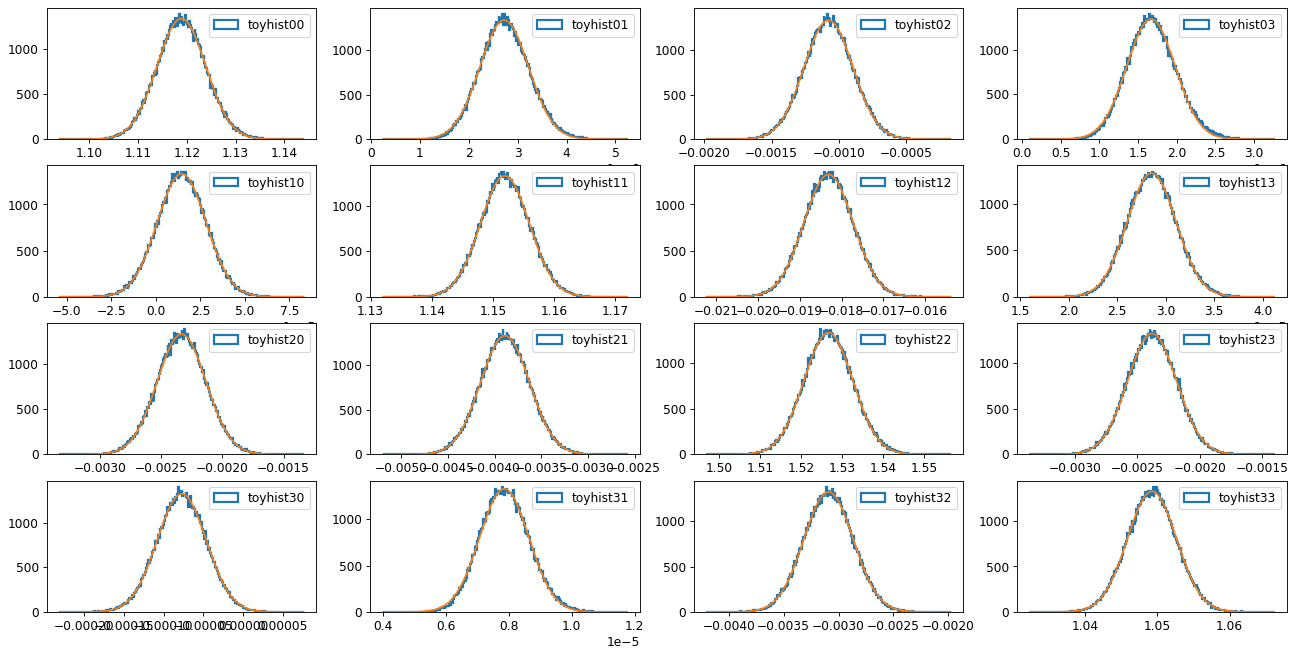

In [10]:
# Define gaussian function to fit to the toy distributions:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


### Number of toy experiments to be done
ntoy = 100000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4,ntoy))

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(ntoy):
    toy_matrix = np.random.normal(selection_rates, selection_errors, size=(4,4))
    
    ### Invert toy matrix
    inverse_toys[:,:,i] = np.linalg.inv(toy_matrix)


inverse_errors = np.zeros((4,4))
inverse_means = np.zeros((4,4))


fig, axes = plt.subplots(4, 4, figsize=(20, 10),dpi=80)


# Fill histograms for each inverted matrix coefficient:
for j in range(4):
    for k in range(4):
        
        ## Calculate empirical mean and standard deviation directly
        mean = np.mean(inverse_toys[j,k,:])
        std = np.sqrt(np.sum((inverse_toys[j,k,:] - mean)**2 )/ (ntoy-1))
        
        # Diagonal and off-diagonal terms have different histogram ranges
        hbins, hedges, _ = axes[j][k].hist(inverse_toys[j,k,:], bins=300, histtype='step', linewidth=2,
                                           range=(mean-5*std, mean+5*std),  label=f'toyhist{j}{k}')
        axes[j][k].legend()

        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) # Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins, maxfev=10000, p0=(1, mean, std))
        
        axes[j][k].plot(h_mid, gauss(h_mid, *coeffs), label=f'Fit{j}{k}')

        inverse_means[j,k] = coeffs[1]
        inverse_errors[j,k] = abs(coeffs[2])

print(f"Errors for the inverse matrix:\n{inverse_errors}")

## Import OPAL data

In [11]:
### Open opal data and read into pandas
path_OPAL = 'opal_data/data/'   # actual data  simulations
OPAL = uproot.open(path_OPAL+'daten_2.root')
OPAL_branches = OPAL[ttree_name].arrays()   # load branches
OPAL_data = ak.to_pandas(OPAL_branches)   # convert to pandas data frame
OPAL_data = OPAL_data[OPAL_data['Pcharged']!=0]   # remove photon-photon contributions

## Use correct NaN specifier for undefined values
OPAL_data['cos_thru'].replace(999, np.nan, inplace=True)
OPAL_data['cos_thet'].replace(999, np.nan, inplace=True)
OPAL_data['Pcharged'].mask(OPAL_data['Pcharged']>100, inplace=True)

## extract different event types
measured_electron = OPAL_data[electron_mask(OPAL_data)]
measured_muon = OPAL_data[muon_mask(OPAL_data)]
measured_tau = OPAL_data[tau_mask(OPAL_data)]
measured_quark = OPAL_data[quark_mask(OPAL_data)]

## Iterable array of different event types
measured_datasets = {'electron': measured_electron, 'muon': measured_muon, 'tau': measured_tau, 'quark': measured_quark}

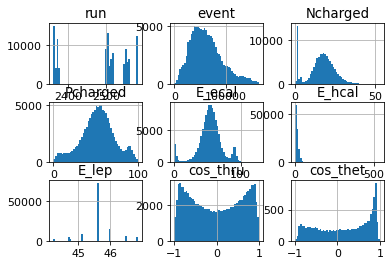

In [12]:
OPAL_data.hist(bins=52)
plt.show()

# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

In [32]:
## define fit function
def t_s_separation(cos_theta, A, B):
    return A * (1 + cos_theta**2) + B * (1 - cos_theta)**(-2)

def s_channel(cos_theta, A, B):
    return A * (1 + cos_theta**2)

def rest(cos_theta, A, B):
    return B * (1 - cos_theta)**(-2)


# this function calibrates the separation, i.e. determine ratio s-channel/total via a curve fit
def perform_t_s_separation(the_input_dataset, make_plot=True, bins=100, limit=0.85):
    ## plot entire histogram and extract bins
    electron_cos_theta, bin_edges, _ = plt.hist(the_input_dataset['cos_thet'],bins=bins, range=(-1.0,1.0),  histtype='stepfilled', label='Pcharged')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    if make_plot:
        plt.tight_layout()
        plt.clf()   #plt.show() if you also want to view the histogram
    
    # mask bins in desired region for curve fit
    curve_fit_mask = np.logical_and(bin_edges[:-1] >= -limit, bin_edges[1:] <= limit)
    
    # calculate curve fit in desired region
    t_s_popt, t_s_pcov = curve_fit(t_s_separation, bin_centers[curve_fit_mask], electron_cos_theta[curve_fit_mask], sigma=np.sqrt(electron_cos_theta[curve_fit_mask]), maxfev=int(1e6), p0=[2, .2])
    t_s_perr = np.sqrt(np.diag(t_s_pcov))
    
    thetas = np.linspace(-limit, limit, 10000)
    # plot results if desired
    if make_plot:
        textstr = '\n'.join((
            r'$P_\mathrm{meas} = a \cdot P_\mathrm{nom}+b$',
            r'$A=(%.3f \pm %.3f)$' % (t_s_popt[0], t_s_perr[0]),
            r'$B=(%.2f \pm %.2f)$' % (t_s_popt[1], t_s_perr[1])))


        props = dict(alpha=1, facecolor='w')

        plt.errorbar(bin_centers, electron_cos_theta, yerr=np.sqrt(electron_cos_theta), fmt='.', ms=3, ecolor='r', elinewidth=1)
        plt.plot(thetas, t_s_separation(thetas, *t_s_popt),lw=0.7, c='purple', label='entire fit')
        plt.plot(thetas, s_channel(thetas, *t_s_popt), lw=0.7, c='lime', label='s-channel contribution')
        plt.plot(thetas, rest(thetas, *t_s_popt), lw=0.7, c='cyan', label='t-channel and interference')
        #plt.text(-0.9, 2000, textstr, fontsize=10, verticalalignment='top', bbox=props)

        plt.xlabel('polar angle $\mathrm{cos}\,(\\theta)$')
        plt.ylabel('counts')
        plt.grid()
        plt.legend()
        plt.show()

    # determine s-channel event number
    electron_s_channel = np.sum(electron_cos_theta * (t_s_popt[0] * (1 + bin_centers**2)) / ((t_s_popt[0] * (1 + bin_centers**2)) + t_s_popt[1] / (1 - bin_centers)**2))
    # propagate individual bin uncertainty to get total statistical uncertainty
    electron_s_channel_u_stat = np.sqrt(np.sum((np.sqrt(electron_cos_theta) * (t_s_popt[0] * (1 + bin_centers**2)) / ((t_s_popt[0] * (1 + bin_centers**2)) + t_s_popt[1] / (1 - bin_centers)**2))**2))
    # propagate fit parameter uncertainty/covariance to get total systematic uncertainty
    t_s_ddA = np.sum(electron_cos_theta * (t_s_popt[1] * (1+bin_centers**2)/((1-bin_centers)**2))/((t_s_popt[0] * (1+bin_centers**2) + t_s_popt[1] * (1+bin_centers**2)/((1-bin_centers)**2))**2))
    t_s_ddB = np.sum(electron_cos_theta * (t_s_popt[0] * (1+bin_centers**2)/((1-bin_centers)**2))/((t_s_popt[0] * (1+bin_centers**2) + t_s_popt[1] * (1+bin_centers**2)/((1-bin_centers)**2))**2))
    electron_s_channel_u_sys = np.sqrt((t_s_ddA * np.sqrt(t_s_pcov[0,0]))**2 + (t_s_ddB * np.sqrt(t_s_pcov[1,1]))**2 + 2 * t_s_ddA * t_s_ddB * t_s_pcov[0,1])
    
    # print results
    print("fit params:     ", t_s_popt[0], t_s_popt[1])
    print("total ee events:", np.sum(electron_cos_theta), "+-", np.sqrt(np.sum(electron_cos_theta)))
    print("s-channel only: ", electron_s_channel, "+-", electron_s_channel_u_stat, "stat. +-", electron_s_channel_u_sys, "sys.")
    
    return electron_s_channel, electron_s_channel_u_stat, electron_s_channel_u_sys
    
    
# calibrate the t-s-selection with the MC data
#t_s_ratio, t_s_ratio_u = calibrate_t_s_separation(simulated_electron, make_plot=False)


# this function performs the t-s-selection with predefined ratio s-channel/total
#def perform_t_s_separation(total_events, total_events_u, t_s_ratio=t_s_ratio, t_s_ratio_u=t_s_ratio_u):
    
    # calculate s-channel event number
#    s_channel_events = t_s_ratio * total_events
    
    # combine total events uncertainty with uncertainty from s-channel/total ratio
#    s_channel_events_u = np.sqrt((t_s_ratio * total_events_u)**2 + (t_s_ratio_u * total_events)**2)
    
    # print results
#    print("total ee events:", total_events, "+-", total_events_u)
#    print("s-channel only: ", s_channel_events, "+-", s_channel_events_u)
    
    # return results
#    return s_channel_events, s_channel_events_u

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [14]:
xs_corrections = pd.DataFrame({ 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                              'hadronic' : [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                              'leptonic' : [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]})

## read csv-file of luminosity data
file = 'opal_data/lumi_files/daten_2.csv'
lumi_data = pd.read_csv(file)

## get the seven different LEP-energies
LEP_energies = np.sort(OPAL_data['E_lep'].round(1).unique())

# print lumi data
lumi_data

,meanenergy,lumi,stat,sys,all
0,88.47777,371.9800,2.594937,2.4881,3.595044
1,89.46906,488.5300,3.009684,3.2730,4.446429
2,90.22324,378.5461,2.670417,2.5339,3.681273
3,91.23965,2072.7930,6.334670,13.8796,15.256840
4,91.96968,540.6800,3.274401,3.6200,4.881198
5,92.97059,369.4000,2.737608,2.4800,3.693900
6,93.71714,353.5000,2.695570,2.3710,3.589950


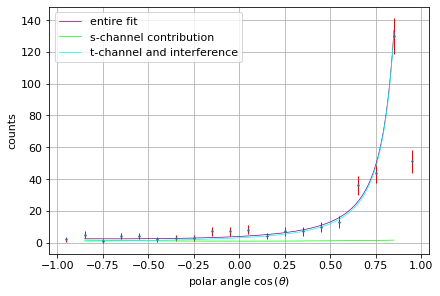

fit params:      0.8827682376758085 2.970057856001516
total ee events: 348.0 +- 18.65475810617763
s-channel only:  26.74829223144028 +- 2.9263681783541244 stat. +- 6.288267431869627 sys.


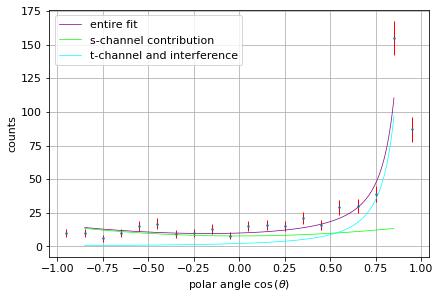

fit params:      7.7759188984848615 2.1824332149812826
total ee events: 531.0 +- 23.043437243605826
s-channel only:  208.18295465065606 +- 11.861506590636386 stat. +- 8.319031655530775 sys.


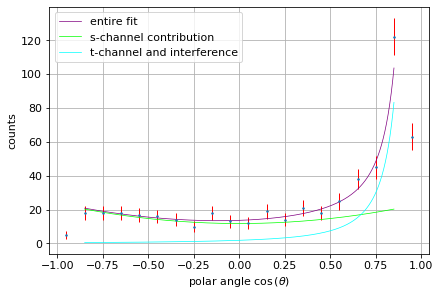

fit params:      11.769214720937486 1.871559321449862
total ee events: 524.0 +- 22.891046284519195
s-channel only:  281.42110566758646 +- 14.551673831081729 stat. +- 5.458371228871622 sys.


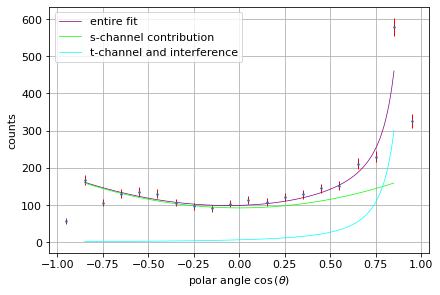

fit params:      92.53078448090805 6.774370659712521
total ee events: 3249.0 +- 57.0
s-channel only:  2264.3891482806334 +- 43.51137099693475 stat. +- 44.317962761276114 sys.


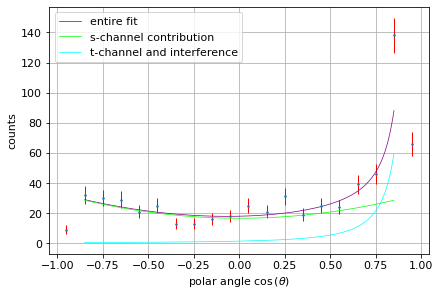

fit params:      16.555715081490785 1.3406902025938903
total ee events: 640.0 +- 25.298221281347036
s-channel only:  424.1491742725223 +- 18.63598013792644 stat. +- 14.207980968184586 sys.


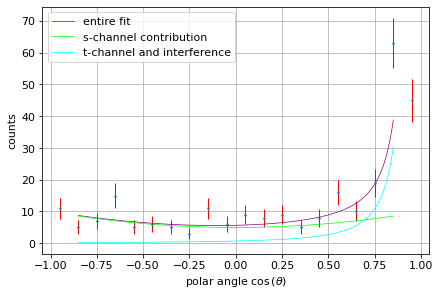

fit params:      4.947070483904079 0.680623670072492
total ee events: 266.0 +- 16.30950643030009
s-channel only:  141.1186753451366 +- 10.427854852488439 stat. +- 6.936619533387083 sys.


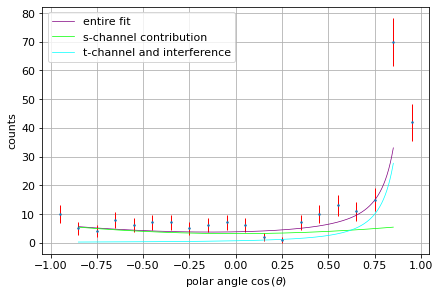

fit params:      3.120658769511402 0.621980481970189
total ee events: 242.0 +- 15.556349186104045
s-channel only:  108.6222914475839 +- 8.908193777019076 stat. +- 7.699938039241444 sys.


In [36]:
## apply t-s-selection to electron events

# prepare array
orig_events = np.zeros((7,4))
orig_events_u = np.zeros((7,4))

# do for all energy values
for e, energy in enumerate(LEP_energies):
    
    # calculate s-channel
    s_channel_only, s_channel_only_u_stat, s_channel_only_u_sys = perform_t_s_separation(measured_electron[measured_electron['E_lep'].round(1) == energy], bins=20)
    
    # write back to datasets
    orig_events[e][0] = s_channel_only
    orig_events_u[e][0] = np.sqrt(s_channel_only_u_stat**2 + s_channel_only_u_sys**2)

In [37]:
## compute the number of measured events according to our selection

# do for all event types and all energy values
for p, (particle, dataset) in enumerate(measured_datasets.items()):
    # we already did electrons in the cell above
    if p == 0:
        continue
    
    for e, energy in enumerate(LEP_energies):
        
        orig_events[e][p] = np.sum(dataset['E_lep'].round(1) == energy)   # count events
        
        orig_events_u[e][p] = np.sqrt(orig_events[e][p])  # calculate Poisson uncertainty
    
    
# print data
pd.DataFrame(orig_events, columns = ['e_events', 'm_events', 't_events', 'q_events'])
#pd.DataFrame(orig_events_u, columns = ['e_events_u', 'm_events_u', 't_events_u', 'q_events_u'])

,e_events,m_events,t_events,q_events
0,26.748292,64.0,85.0,1968.0
1,208.182955,196.0,178.0,4763.0
2,281.421106,279.0,232.0,6777.0
3,2264.389148,2398.0,2104.0,60365.0
4,424.149174,541.0,441.0,12717.0
5,141.118675,185.0,181.0,5045.0
6,108.622291,136.0,122.0,3408.0


In [38]:
## correct the measured events using the inverted efficiency matrix

# prepare array
corr_events = np.zeros((7,4))
corr_events_u = np.zeros((7,4))

# do for all energy values
for e in range(7):
    
    # calculate "true" event numbers using inverted efficiency matrix
    corr_events[e] = inverse_means @ orig_events[e]
    
    # propagate uncertainties (cannot be done in form of matrix multiplication because of the exponent 2)
    for p in range(4):
        
        # propagate uncertainties from inverted matrix
        u_correction_sum = np.sum((inverse_errors[p] * orig_events[e])**2)
        
        # propagate Poisson uncertainties
        u_poisson_sum = np.sum((inverse_means[p] * orig_events_u[e])**2)
        
        # combine uncertainties
        corr_events_u[e][p] = np.sqrt(u_correction_sum + u_poisson_sum)
    
        
# print data
pd.DataFrame(corr_events, columns = ['e_events', 'm_events', 't_events', 'q_events'])
#pd.DataFrame(corr_events_u, columns = ['e_events_u', 'm_events_u', 't_events_u', 'q_events_u'])

,e_events,m_events,t_events,q_events
0,29.839352,72.226704,124.766932,2064.646025
1,232.743260,222.667437,259.151490,4996.979915
2,314.631542,317.351470,336.299703,7109.983500
3,2531.363726,2725.674586,3053.686056,63330.897246
4,474.109029,615.514566,639.869880,13341.832235
5,157.705268,209.947788,263.258951,5292.862273
6,121.407221,154.534014,177.351905,3575.435893


In [39]:
## calculate cross sections

# prepare arrays
cross_section = np.zeros((7,4))
cross_section_u = np.zeros((7,4))

# do for all energies
for e in range(7):
    # calculate cross section
    cross_section[e] = corr_events[e] / lumi_data['lumi'][e]
    
    # propagate uncertainties
    for p in range(4):
        cross_section_u[e][p] = cross_section[e][p] * \
            np.sqrt((corr_events_u[e][p]/corr_events[e][p])**2 + (lumi_data['all'][e]/lumi_data['lumi'][e])**2)


## apply radiation corrections
for e in range(7):
    
    # correct lepton data
    cross_section[e][0] += xs_corrections['leptonic'][e]
    cross_section[e][1] += xs_corrections['leptonic'][e]
    cross_section[e][2] += xs_corrections['leptonic'][e]
    
    # correct hadron data
    cross_section[e][3] += xs_corrections['hadronic'][e]
        
# print data
pd.DataFrame(cross_section, columns=['sigma_ee', 'sigma_mm', 'sigma_tt', 'sigma_qq'])
#pd.DataFrame(cross_section_u, columns=['sigma_ee_u', 'sigma_mm_u', 'sigma_tt_u', 'sigma_qq_u'])

,sigma_ee,sigma_mm,sigma_tt,sigma_qq
0,0.170218,0.284168,0.425413,7.550422
1,0.676415,0.655791,0.730472,14.528604
2,1.191158,1.198343,1.248398,26.482345
3,1.741233,1.834977,1.993223,41.353411
4,1.096875,1.358408,1.403454,29.376023
5,0.416923,0.558348,0.702666,14.128268
6,0.263443,0.357154,0.421703,8.514387


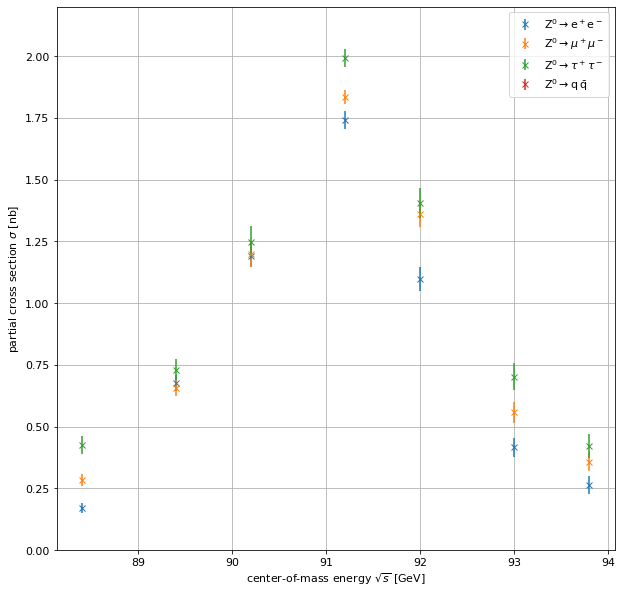

In [40]:
## plot cross sections to energies

plt.figure(figsize=(10, 10))

for p, particle in enumerate(['$\\mathrm{Z}^0\\rightarrow\\mathrm{e}^+\\mathrm{e}^-$',
                             '$\\mathrm{Z}^0\\rightarrow\\mu^+\\mu^-$',
                             '$\\mathrm{Z}^0\\rightarrow\\tau^+\\tau^-$',
                             '$\\mathrm{Z}^0\\rightarrow\\mathrm{q}\\,\\bar{\\mathrm{q}}$']):
    plt.errorbar(2*LEP_energies, cross_section[:,p], yerr=cross_section_u[:,p], fmt="x", label=particle)

plt.xlabel("center-of-mass energy $\\sqrt{s}$ [$\\mathrm{GeV}$]")
plt.ylabel("partial cross section $\\sigma$ [$\\mathrm{nb}$]")
plt.legend()
plt.ylim(0, 2.2)
plt.grid()
plt.show()

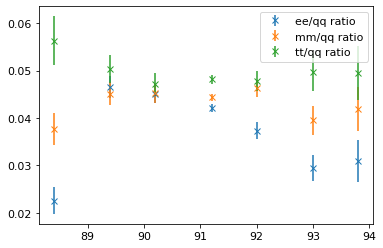

In [47]:
## calculate ratios between leptonic and hadronic cross section

# prepare arrays
lepton_to_hadron_ratios = np.zeros((7,3))
lepton_to_hadron_ratios_u = np.zeros((7,3))

# do for all energies
for e in range(7):
    # devide lepton cross sections by hadronic cross section
    lepton_to_hadron_ratios[e] = cross_section[e,:-1] / cross_section[e,-1]
    
    # propagate uncertainties
    for p in range(3):
        lepton_to_hadron_ratios_u[e][p] = lepton_to_hadron_ratios[e][p] * \
            np.sqrt((cross_section_u[e][p]/cross_section[e][p])**2 + (cross_section_u[e][-1]/cross_section[e][-1])**2)


## plot results
for p, particle in enumerate(['ee/qq ratio', 'mm/qq ratio', 'tt/qq ratio']):
    plt.errorbar(2*LEP_energies, lepton_to_hadron_ratios[:,p], yerr=lepton_to_hadron_ratios_u[:,p], fmt="x", label=particle)

#plt.ylim(0.03, 0.06)
plt.legend()
plt.show()

91.08209293322146 +- 0.05526672850235609
2.2711319855236067 +- 0.15219392462961062
1.8604914586295553 +- 0.08594778573381909


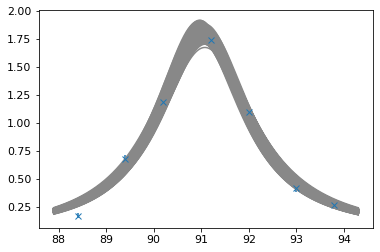

(array([91.03548485,  2.31503155,  1.80115861]),
 array([0.03209099, 0.07149762, 0.03727992]))

In [45]:
## fit Breit-Wigner functions

# define Breit-Wigner function
def breit_wigner(s, mass, gamma, peak):
    return peak * s / (((s - mass**2)**2 / gamma**2) + (s**2 / mass**2))

# define Gaussian function
def gaussian(x, x_0, sigma, a):
    return a * np.exp(-(x-x_0)**2 / (2*sigma**2))


def perform_breit_wigner_fits(particle_index, repetitions=int(1e3)):
    particle = particle_index

    LEP_s = 2*LEP_energies

    # prepare arrays
    bw_popts = np.zeros((repetitions, 3))
    fit_cross_sections = np.repeat([cross_section[:,particle]], repetitions, axis=0)

    # add normal distributed deviations
    for e in range(7):
        fit_cross_sections[:,e] += np.random.normal(0.0, cross_section_u[e,particle], repetitions)

    # fit a lot of times
    for i in range(repetitions):

        # perform curve fit
        bw_popt, bw_pcov = curve_fit(breit_wigner, LEP_s**2, fit_cross_sections[i], p0=[91, 3, 40], maxfev=int(1e6))

        # store results
        bw_popts[i] = bw_popt

        # print if desired
        if i == 27:
            print(bw_popt[0], "+-", np.sqrt(bw_pcov[0,0]))
            print(bw_popt[1], "+-", np.sqrt(bw_pcov[1,1]))
            print(bw_popt[2], "+-", np.sqrt(bw_pcov[2,2]))

        # plot if desired
        energies = np.linspace(np.amin(LEP_s)-.5, np.amax(LEP_s)+.5, int(1e4))
        plt.plot(energies, breit_wigner(energies**2, *bw_popt), c="#888888")

    # plot original cross sections on top of fits
    plt.errorbar(LEP_s, cross_section[:,particle], yerr=cross_section_u[:,particle], fmt="x")
    plt.show()


    # calculate mean fit parameters
    bw_popt = np.mean(bw_popts, axis=0)
    # estimate uncertainty via sample standard deviation
    bw_perr = np.sqrt(np.sum((bw_popts-np.repeat([bw_popt], repetitions, axis=0))**2, axis=0)/(repetitions-1))

    # return fit params and estimated uncertainties
    return bw_popt, bw_perr


# define variables
#bw_fit_params = np.zeros(4, 3)
perform_breit_wigner_fits(0)

# Exercise 4: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

In [209]:
radiation_corrections = pd.DataFrame({ 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                                'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]})

In [231]:
# calculate the counts forwards and backwards
forward_sim = sum(simulated_muon['cos_thet'] > 0)
backward_sim = sum(simulated_muon['cos_thet'] < 0)

# uncertainties according to poission
u_f_sim = np.sqrt(forward_sim)
u_b_sim = np.sqrt(backward_sim)

# calculate forward-backward assym. and uncertainty
AFB_sim = (forward_sim - backward_sim) / (forward_sim + backward_sim) + radiation_corrections['correction'][3]
u_AFB_sim = np.sqrt( ((2*backward_sim)/(forward_sim + backward_sim)**2 * u_f_sim)**2 
                    + ((2*forward_sim)/(forward_sim + backward_sim)**2 * u_b_sim)**2)

# calculate weinberg angle and uncertainty
sinsq_thetaW_sim = 0.25 - np.sqrt(AFB_sim/3) / 4
u_sinsq_thetaW_sim = 1 / (8 * np.sqrt(3) * np.sqrt(AFB_sim))

print(sinsq_thetaW_sim, u_sinsq_thetaW_sim)

0.22792674555252468 0.47191349564939616


# Exercise 5: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.

In [215]:
(forward_sim - backward_sim) / (forward_sim + backward_sim)

0.005093970971343505

In [232]:
u_f_sim

207.8725571113224

In [233]:
forward_sim

43211

In [234]:
backward_sim

42773